In [63]:
import torch
import torch.nn.functional as F
import json, os
import h5py
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image, ImageDraw

In [64]:
from tqdm import tqdm

In [65]:
from sklearn.metrics import confusion_matrix
import scipy as sp
import seaborn as sns
from scipy.cluster import hierarchy
from sklearn.cluster import KMeans
import copy
from sklearn.cluster import SpectralClustering

In [66]:
project_dir = '/home/miskai/デスクトップ/related-work/scene-graph-benchmark'
image_file = json.load(open(f'{project_dir}/datasets/vg/image_data.json'))
vocab_file = json.load(open(f'{project_dir}/datasets/vg/VG-SGG-dicts-with-attri.json'))
data_file = h5py.File(f'{project_dir}/datasets/vg/VG-SGG-with-attri.h5', 'r')
# remove invalid image
corrupted_ims = [1592, 1722, 4616, 4617]
tmp = []
for item in image_file:
    if int(item['image_id']) not in corrupted_ims:
        tmp.append(item)
image_file = tmp

In [67]:
idx2pred = vocab_file["idx_to_predicate"]

# Visual tree

In [8]:
labels = np.array([idx2pred[str(l)] for l in range(1,51)], dtype=str)

## data from npy file

In [68]:
rel_info_path = "../checkpoints/motifs-sgcls-exmp/causal-lr1e-2/vis_record/rel.npy"

In [69]:
# data = np.concatenate((ctx_info["avg_feature"][1:], frq_info["avg_feature"][1:], vis_info["avg_feature"][1:]), 1)
data = np.load(rel_info_path, allow_pickle=True).item()['avg_feature'][1:]

## Hierarchical Clustering

In [70]:
z = hierarchy.linkage(data, method="ward", metric="euclidean")

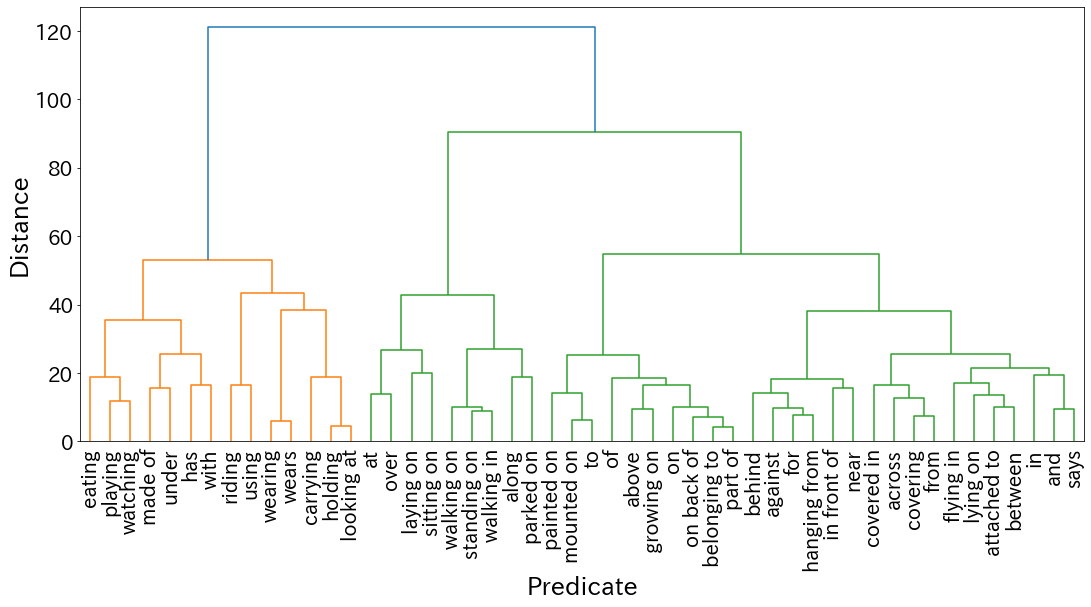

In [71]:
plt.figure(figsize=(18,8))
plt.xlabel("Predicate", fontsize=25)
plt.ylabel("Distance", fontsize=25)
ax = hierarchy.dendrogram(z, show_contracted=True, labels=labels, color_threshold=100)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
save_file = os.path.join("/".join(rel_info_path.split("/")[:-2]), "clustering.pdf")
plt.savefig(save_file, dpi=300, bbox_inches="tight")
plt.show()

In [72]:
cls = hierarchy.fcluster(z, t=2, criterion="maxclust")
len(set(cls))

2

In [77]:
labels = np.array(labels, dtype=str)
for i in range(1,len(set(cls))+1):
    print(f"Group {i}:")
    print('"' + '" ,"'.join(labels[cls==i]) + '"')

Group 1:
"carrying" ,"eating" ,"has" ,"holding" ,"looking at" ,"made of" ,"playing" ,"riding" ,"under" ,"using" ,"watching" ,"wearing" ,"wears" ,"with"
Group 2:
"above" ,"across" ,"against" ,"along" ,"and" ,"at" ,"attached to" ,"behind" ,"belonging to" ,"between" ,"covered in" ,"covering" ,"flying in" ,"for" ,"from" ,"growing on" ,"hanging from" ,"in" ,"in front of" ,"laying on" ,"lying on" ,"mounted on" ,"near" ,"of" ,"on" ,"on back of" ,"over" ,"painted on" ,"parked on" ,"part of" ,"says" ,"sitting on" ,"standing on" ,"to" ,"walking in" ,"walking on"
